In [ ]:
project_path = '/content/drive/MyDrive/Colab Notebooks/polyp segmentation'

In [ ]:
# !unzip "/content/drive/MyDrive/Colab Notebooks/polyp segmentation/data/archive.zip" -d "/content/drive/MyDrive/Colab Notebooks/polyp segmentation/data/"

In [ ]:
import matplotlib.pyplot as plt
import skimage.io
import numpy as np
import os
import random
import shutil

# example of loading an image with the Keras API

import keras
from keras.preprocessing.image import load_img, img_to_array
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from tensorflow.keras.layers import BatchNormalization
from keras import backend as K
from IPython.display import clear_output

from sklearn.metrics import roc_auc_score
from numpy.random import seed
from tensorflow.random import set_seed
import time
from __future__ import with_statement

%matplotlib inline
# plots in jupyter notebooks
%matplotlib inline

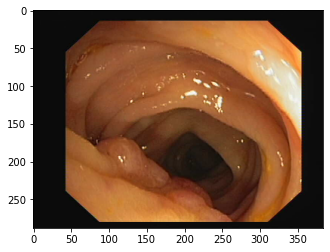

In [ ]:
# Load an original image
original = skimage.io.imread(project_path + '/data/TIF/Original/1.tif', plugin='tifffile')
plt.imshow(original) # plot image

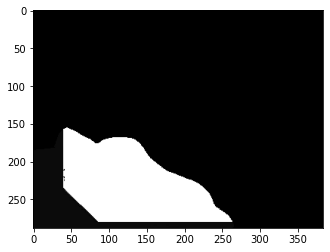

In [ ]:
# Load the ground truth image
thruth = load_img( project_path + '/data/TIF/Ground Truth/1.tif')
thruth_array = img_to_array(thruth)  # this is a Numpy array
thruth_array = thruth_array * 1./255 # image normalization for keras
plt.imshow(thruth_array)             # plot image

In [ ]:
# Define the image folders for the downloaded images = to be processed
OriginalFolder    = project_path+'/data/TIF/Original'
GroundTruthFolder = project_path+'/data/TIF/Ground Truth'

# Define the image folders for the cropped images = resulted from this script
PolypsFolder      = project_path+'/cropped/polyps'
nonPolypsFolder   = project_path+'/cropped/non_polyps'

# Minimum box to crop for non-polyp images
min_box = 150 # get box of 150 x 150 pixels

In [ ]:
orFiles = os.listdir(OriginalFolder)
gtFiles = os.listdir(GroundTruthFolder)
print('Original files:', OriginalFolder, len(orFiles), '\nGround Truth files:', GroundTruthFolder, len(gtFiles))

Original files: /content/drive/MyDrive/Colab Notebooks/polyp segmentation/data/TIF/Original 612 
Ground Truth files: /content/drive/MyDrive/Colab Notebooks/polyp segmentation/data/TIF/Ground Truth 612


In [ ]:
# Crop polys as new images
print('--> Cropping polyps as images ...')
# For each image in Original folder
for iFile in orFiles:
    # Get full path for original / source image = folder + filename
    sourceFile = os.path.join(OriginalFolder,iFile)
    # Get full path for polyp location image = folder + filename
    locationFile = os.path.join(GroundTruthFolder,iFile)
    # Get full path for polyp cropped image = folder + filename
    polypFile = os.path.join(PolypsFolder,iFile)
    # Get full path for non-polyp cropped image = folder + filename
    nonpolypFile = os.path.join(nonPolypsFolder,iFile)
    
    # Read the original image
    img_o_array = skimage.io.imread(sourceFile, plugin='tifffile') # array with pixel data
    # Remove black margins using manual values from trials
    img_o_array = img_o_array[30:280,90:220+90,:]
    
    # Read ground truth image
    img_gt = load_img(locationFile)
    img_gt_array = img_to_array(img_gt)  # this is a Numpy array
    img_gt_array = img_gt_array * 1./255 # image normalization for keras
    # Remove the black margins
    img_gt_array = img_gt_array[30:280,90:220+90,:]
    
    # Apply mask for ground truth image: find non-black pixels!
    mask = img_gt_array > [0,0,0] # using 3 channels
    # Get coordinates of non-black pixels using only one channel data!
    coords = np.argwhere(mask[:,:,0])
    # Set bounding box of non-black pixels (used to define the polyp cropping area)
    x0, y0 = coords.min(axis=0)
    x1, y1 = coords.max(axis=0) + 1   # slices are exclusive at the top
    
    # Get the cropped image with a polyp from the original image
    cropped = img_o_array[x0:x1, y0:y1,:]
    
    # SAVE the croped image as a polyp image in 'cropped/1-Polyps' (jpg format)
    plt.imsave(polypFile[:-4]+'.jpg', cropped)

print('Done!')

--> Cropping polyps as images ...
Done!


/content/drive/MyDrive/Colab Notebooks/polyp segmentation/cropped/polyps/77.jpg


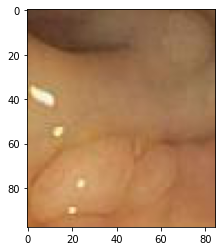

In [ ]:
one_polyp = skimage.io.imread(polypFile[:-4]+'.jpg')
print(polypFile[:-4]+'.jpg')
plt.imshow(one_polyp) # plot image

In [ ]:
# Crop non-polys as new images (one image for each polyp)
print('--> Cropping non-polyps as images ...')
# For each image in Original folder
for iFile in orFiles:
    # Get full path for original / source image = folder + filename
    sourceFile = os.path.join(OriginalFolder,iFile)
    # Get full path for polyp location image = folder + filename
    locationFile = os.path.join(GroundTruthFolder,iFile)
    # Get full path for polyp cropped image = folder + filename
    polypFile = os.path.join(PolypsFolder,iFile)
    # Get full path for non-polyp cropped image = folder + filename
    nonpolypFile = os.path.join(nonPolypsFolder,iFile)
    
    # Read the original image
    img_o_array = skimage.io.imread(sourceFile, plugin='tifffile') # array with pixel data
    # Remove black margins using manual values from trials
    img_o_array = img_o_array[30:280,90:220+90,:]
    
    # Read ground truth image
    img_gt = load_img(locationFile)
    img_gt_array = img_to_array(img_gt)  # this is a Numpy array
    img_gt_array = img_gt_array * 1./255 # image normalization for keras
    # Remove the black margins
    img_gt_array = img_gt_array[30:280,90:220+90,:]
    
    # Apply mask for ground truth image: find non-black pixels!
    mask = img_gt_array > [0,0,0] # using 3 channels
    # Get coordinates of non-black pixels using only one channel data!
    coords = np.argwhere(mask[:,:,0])
    # Set bounding box of non-black pixels (used to define the polyp cropping area)
    x0, y0 = coords.min(axis=0)
    x1, y1 = coords.max(axis=0) + 1   # slices are exclusive at the top
    
    # Get one of the 4 images from left, right, up and bottom to the polyp
    # Get original image x, y (image dimension)
    x, y, ch = img_o_array.shape
    
    
    # Get one section fron up or down (relative to the polyp)
    if (x - x1) > x0:
        x_i = x1
        x_f = x
        y_i = 0
        y_f = y
    else:
        x_i = 0
        x_f = x0
        y_i = 0
        y_f = y
    up_down = img_o_array[x_i:x_f,y_i:y_f,:]
    
    # Get one section fron left or rigth (relative to the polyp)
    if (y - y1) > y0:
        y_i = y1
        y_f = y
        x_i = 0
        x_f = x
    else:
        y_i = 0
        y_f = y0
        x_i = 0
        x_f = x
        
    left_right = img_o_array[x_i:x_f,y_i:y_f,:]
    
    # If area of up_down image is greater than left_right, save as non_polyp the up_down image; else save left-right
    surface_up_down    = up_down.shape[0] * up_down.shape[1]
    surface_left_right = left_right.shape[0] * left_right.shape[1]
    if surface_up_down > surface_left_right:
        non_polyp = up_down
    else:
        non_polyp = left_right
    # If surface of the result is different of zero, save it!
    surface_non_polyp = non_polyp.shape[0] * non_polyp.shape[1]
    if surface_non_polyp!=0:
        plt.imsave(nonpolypFile[:-4]+'.jpg', non_polyp)
    else:
        # If non-polyp area is zero print an error message
        print('Without non-polys:', nonpolypFile)

print("Done!")

--> Cropping non-polyps as images ...
Without non-polys: /content/drive/MyDrive/Colab Notebooks/polyp segmentation/cropped/non_polyps/22.tif
Without non-polys: /content/drive/MyDrive/Colab Notebooks/polyp segmentation/cropped/non_polyps/478.tif
Without non-polys: /content/drive/MyDrive/Colab Notebooks/polyp segmentation/cropped/non_polyps/490.tif
Done!


In [ ]:
# Remove a specific list of files from cropped polyps
for iFileToRemove in [55, 67, 178, 329, 559, 82]:
    # Get full path for polyp cropped image = folder + filename
    polypFile = os.path.join(PolypsFolder,str(iFileToRemove)+'.jpg')
    try:
        print("--> Removing file:", polypFile)
        os.remove(polypFile)
    except:
        print("----> Error:", polypFile, "do not exists!")



# Remove a specific list of files from cropped non-polyps
for iFileToRemove in [25, 476, 477]:
    # Get full path for polyp cropped image = folder + filename
    nonpolypFile = os.path.join(nonPolypsFolder,str(iFileToRemove)+'.jpg')
    try:
        print("--> Removing file:", nonpolypFile)
        os.remove(nonpolypFile)
    except:
        print("----> Error:", nonpolypFile, "do not exists!")

--> Removing file: /content/drive/MyDrive/Colab Notebooks/polyp segmentation/cropped/polyps/55.jpg
--> Removing file: /content/drive/MyDrive/Colab Notebooks/polyp segmentation/cropped/polyps/67.jpg
--> Removing file: /content/drive/MyDrive/Colab Notebooks/polyp segmentation/cropped/polyps/178.jpg
--> Removing file: /content/drive/MyDrive/Colab Notebooks/polyp segmentation/cropped/polyps/329.jpg
--> Removing file: /content/drive/MyDrive/Colab Notebooks/polyp segmentation/cropped/polyps/559.jpg
--> Removing file: /content/drive/MyDrive/Colab Notebooks/polyp segmentation/cropped/polyps/82.jpg
--> Removing file: /content/drive/MyDrive/Colab Notebooks/polyp segmentation/cropped/non_polyps/25.jpg
--> Removing file: /content/drive/MyDrive/Colab Notebooks/polyp segmentation/cropped/non_polyps/476.jpg
--> Removing file: /content/drive/MyDrive/Colab Notebooks/polyp segmentation/cropped/non_polyps/477.jpg


In [12]:
print('Cropped polyps:', len(os.listdir(PolypsFolder)), '\nCropped non-polyps:', len(os.listdir(nonPolypsFolder)))

Cropped polyps: 606 
Cropped non-polyps: 606


/content/drive/MyDrive/Colab Notebooks/polyp segmentation/cropped/polyps/82.jpg


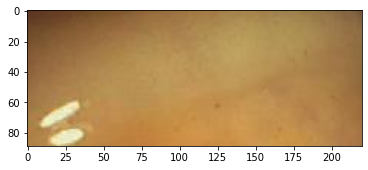

In [15]:
one_nonpolyp = skimage.io.imread(nonpolypFile[:-5]+'.jpg')
print(polypFile[:-4]+'.jpg')
plt.imshow(one_nonpolyp) # plot image

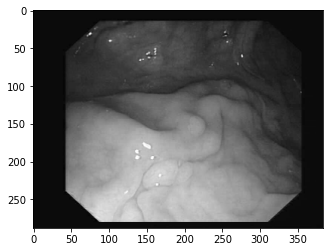

In [16]:
import cv2 as cv
test = cv.imread(sourceFile,cv.IMREAD_COLOR)
plt.imshow(test) # plot image